# Analysis

## Libraries

In [5]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
import numpy as np

## Education

### Preparation

In [30]:
# Load the individual CSV files
baseline_df = pd.read_csv("data/education/processed/2_education_baseline.csv")
compression_df = pd.read_csv("data/education/processed/2_education_compression.csv")
cookbook_df = pd.read_csv("data/education/processed/2_education_cookbook.csv")
hyde_df = pd.read_csv("data/education/processed/2_education_hyde.csv")

# Define columns to add prefixes to, which are transformation-specific
transformation_specific_cols = ['token_query', 'token_query_full_prompt', 'total_token_size', 
                                'transformation_latency', 'generated_answer', 'gpt_score',
                                'Recall@k', 'MRR', 'nDCG@k', 'total_latency']

# Function to add prefixes to transformation-specific columns
def add_prefix(df, prefix, columns):
    df = df.rename(columns={col: f"{prefix}_{col}" for col in columns})
    # Rename non-transformation-specific columns (e.g., query, latency) to avoid duplication
    return df.rename(columns={col: f"{prefix}_{col}" for col in ['query', 'retrieval_generation_latency']})

# Apply renaming with prefixes for each transformation DataFrame
baseline_df = add_prefix(baseline_df, 'baseline', transformation_specific_cols)
compression_df = add_prefix(compression_df, 'compression', transformation_specific_cols)
cookbook_df = add_prefix(cookbook_df, 'rewriting', transformation_specific_cols)
hyde_df = add_prefix(hyde_df, 'hyde', transformation_specific_cols)

# Merge all DataFrames on shared columns (context, question, answer, topic_lda)
# Specify suffixes to handle any potential overlapping non-prefixed columns
unified_df = baseline_df.merge(compression_df, on=['context', 'question', 'answers', 'topic_lda', 'question_class'], how='outer') \
                        .merge(cookbook_df, on=['context', 'question', 'answers', 'topic_lda', 'question_class'], how='outer') \
                        .merge(hyde_df, on=['context', 'question', 'answers', 'topic_lda', 'question_class'], how='outer')

unified_df.rename(columns={'answers':'answer'}, inplace=True)

# Display first results
unified_df.head()

,context,question,answer,topic_lda,question_class,baseline_query,baseline_token_query,baseline_token_query_full_prompt,baseline_total_token_size,baseline_Recall@k,...,hyde_token_query_full_prompt,hyde_total_token_size,hyde_Recall@k,hyde_MRR,hyde_nDCG@k,hyde_transformation_latency,hyde_retrieval_generation_latency,hyde_total_latency,hyde_generated_answer,hyde_gpt_score
0,\nA gene is a locus (or region) of DNA that en...,What is a gene?,a locus (or region) of DNA that encodes a func...,1,DESC,What is a gene?,5.0,704.0,708,1.0,...,1102.0,1499,1.0,1.0,1.0,3.331621,1.310691,5.827771,Locus of DNA encoding functional product,0.8
1,"""Poultry"" is a term used for any kind of domes...",Who is the authoor of the book Poultry Breedin...,R. D. Crawford,1,HUM,Who is the authoor of the book Poultry Breedin...,15.0,1643.0,1648,1.0,...,1756.0,1997,1.0,1.0,1.0,1.932973,1.554497,9.530728,R. D. Crawford,1.0
2,"15th Street starts at FDR Drive, and 16th Stre...",Where does 15th Street start?,FDR Drive,3,LOC,Where does 15th Street start?,8.0,702.0,705,1.0,...,1052.0,1447,1.0,1.0,1.0,5.596908,0.963446,7.506958,FDR Drive,1.0
3,1762 brought two new countries into the war. B...,Identify a new country that joined the war in ...,Spain,0,LOC,Identify a new country that joined the war in ...,13.0,1358.0,1359,1.0,...,1797.0,2232,1.0,1.0,1.0,4.635262,1.123329,6.838142,Spain,1.0
4,181st Street is served by two New York City Su...,How many metres apart are 181st Street's two s...,500,3,NUM,How many metres apart are 181st Street's two s...,14.0,583.0,585,1.0,...,845.0,1173,1.0,1.0,1.0,2.319246,1.001181,4.322119,500 metres,0.5


In [31]:
unified_df.columns

Index(['context', 'question', 'answer', 'topic_lda', 'question_class',
       'baseline_query', 'baseline_token_query',
       'baseline_token_query_full_prompt', 'baseline_total_token_size',
       'baseline_Recall@k', 'baseline_MRR', 'baseline_nDCG@k',
       'baseline_transformation_latency',
       'baseline_retrieval_generation_latency', 'baseline_total_latency',
       'baseline_generated_answer', 'baseline_gpt_score', 'compression_query',
       'compression_token_query', 'compression_token_query_full_prompt',
       'compression_total_token_size', 'compression_Recall@k',
       'compression_MRR', 'compression_nDCG@k',
       'compression_transformation_latency',
       'compression_retrieval_generation_latency', 'compression_total_latency',
       'compression_generated_answer', 'compression_gpt_score',
       'rewriting_query', 'rewriting_token_query',
       'rewriting_token_query_full_prompt', 'rewriting_total_token_size',
       'rewriting_Recall@k', 'rewriting_MRR', 'rewri

### Quality Check

In [32]:
# Check for missing values across the DataFrame
missing_values = unified_df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])

Missing values in each column:
 compression_query               2
compression_generated_answer    1
rewriting_generated_answer      2
hyde_generated_answer           1
dtype: int64


In [33]:
# Check initial row count
initial_count = len(unified_df)
print(f"Initial row count: {initial_count}")

# Columns with missing values to remove
columns_to_check = ['compression_query', 'compression_generated_answer', 'hyde_generated_answer']

# Remove rows with missing values in the specified columns
unified_df_cleaned = unified_df.dropna(subset=columns_to_check)

# Check final row count
final_count = len(unified_df_cleaned)
print(f"Final row count after removing missing values: {final_count}")

# Confirm the removed rows
print(f"Number of rows removed: {initial_count - final_count}")

Initial row count: 929
Final row count after removing missing values: 926
Number of rows removed: 3


In [34]:
# Check for duplicate rows based on essential columns
duplicates = unified_df_cleaned.duplicated(subset=['context', 'question', 'answer', 'topic_lda', 'question_class'])
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [35]:
# Check if metric columns fall within expected ranges
metric_columns = [col for col in unified_df_cleaned.columns if 'Recall@k' in col or 'MRR' in col or 'nDCG@k' in col]
for col in metric_columns:
    assert unified_df_cleaned[col].between(0, 1).all(), f"Values out of range in column: {col}"

# Check for non-negative latency values
latency_columns = [col for col in unified_df.columns if 'latency' in col]
for col in latency_columns:
    assert (unified_df_cleaned[col] >= 0).all(), f"Negative values found in column: {col}"

In [36]:
# Check for both NaN and empty string values
def find_missing_and_empty_values(df):
    # Identify columns with NaN values
    nan_counts = df.isna().sum()
    nan_counts = nan_counts[nan_counts > 0]
    
    # Identify columns with empty strings or whitespace only
    empty_counts = (df.applymap(lambda x: isinstance(x, str) and x.strip() == '')
                    .sum())
    empty_counts = empty_counts[empty_counts > 0]
    
    # Combine the counts
    missing_info = pd.DataFrame({'NaN Count': nan_counts, 'Empty String Count': empty_counts}).fillna(0)
    
    print("Columns with missing or empty values:\n", missing_info)

# Call the function on your unified DataFrame
find_missing_and_empty_values(unified_df_cleaned)

Columns with missing or empty values:
                             NaN Count  Empty String Count
rewriting_generated_answer          1                 0.0


C:\Users\Emir\AppData\Local\Temp\ipykernel_3352\100012373.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_counts = (df.applymap(lambda x: isinstance(x, str) and x.strip() == '')


In [38]:
# Count the rows pre-cleaning
print("Row count before cleaning:", unified_df_cleaned.shape[0])

# Remove rows with NaN in the specified column
unified_df_cleaned = unified_df_cleaned.dropna(subset=['rewriting_generated_answer'])

# Count the rows post-cleaning
print("Row count after cleaning:", unified_df_cleaned.shape[0])

Row count before cleaning: 926
Row count after cleaning: 925


In [39]:
# Load the original CSV files into a dictionary with transformation names as keys
original_files = {
    'baseline': pd.read_csv("data/education/processed/2_education_baseline.csv"),
    'compression': pd.read_csv("data/education/processed/2_education_compression.csv"),
    'rewriting': pd.read_csv("data/education/processed/2_education_cookbook.csv"),
    'hyde': pd.read_csv("data/education/processed/2_education_hyde.csv")
}

def print_random_question_and_compare(df):
    # Randomly select a row from the unified DataFrame
    random_index = random.choice(df.index)
    selected_row = df.loc[random_index]
    question = selected_row['question']
    
    # Randomly choose one transformation type
    transformation = random.choice(list(original_files.keys()))
    original_df = original_files[transformation]
    
    print(f"\nRandomly selected transformation: {transformation}")
    print("Values in unified_df for the selected question and transformation:")
    
    # Define columns of interest and add transformation prefix for unified_df
    base_columns = ['context', 'question', 'answer', 'topic_lda', 'query', 
                    'Recall@k', 'MRR', 'nDCG@k', 'generated_answer', 'gpt_score']
    prefixed_columns = [f"{transformation}_{col}" for col in base_columns]
    
    # Filter to only include available prefixed columns in unified_df
    available_columns = [col for col in prefixed_columns if col in df.columns]
    
    # Print the selected row's values for the transformation
    print(selected_row[available_columns])

    # Look up the same question in the selected original file
    original_row = original_df[original_df['question'] == question]
    
    # Print out values from the original file if the question is found
    if not original_row.empty:
        print(f"\nOriginal values from '{transformation}' CSV for the same question:")
        available_columns_original = [col for col in base_columns if col in original_row.columns]
        print(original_row[available_columns_original].iloc[0])
    else:
        print(f"\nQuestion not found in the original '{transformation}' CSV.")

# Run the function on the unified DataFrame
print_random_question_and_compare(unified_df_cleaned)


Randomly selected transformation: rewriting
Values in unified_df for the selected question and transformation:
rewriting_query               In 1373, Portugal formed a pact with which nat...
rewriting_Recall@k                                                          1.0
rewriting_MRR                                                               1.0
rewriting_nDCG@k                                                            1.0
rewriting_generated_answer                                              England
rewriting_gpt_score                                                         1.0
Name: 302, dtype: object

Original values from 'rewriting' CSV for the same question:
context             In 1348 and 1349 Portugal, like the rest of Eu...
question            In 1373, Portugal made an alliance with which ...
topic_lda                                                           0
query               In 1373, Portugal formed a pact with which nat...
Recall@k                                  

In [41]:
print_random_question_and_compare(unified_df_cleaned)


Randomly selected transformation: hyde
Values in unified_df for the selected question and transformation:
hyde_query               Which American broadcaster shows the Premier L...
hyde_Recall@k                                                          1.0
hyde_MRR                                                               1.0
hyde_nDCG@k                                                            1.0
hyde_generated_answer                                           NBC Sports
hyde_gpt_score                                                         1.0
Name: 693, dtype: object

Original values from 'hyde' CSV for the same question:
context             The Premier League is broadcast in the United ...
question            Which American broadcaster shows the Premier L...
topic_lda                                                           3
query               Which American broadcaster shows the Premier L...
Recall@k                                                          1.0
MRR         

In [42]:
# Save as new analysis dataset
unified_df_cleaned.to_csv("data/education/processed/3_education_analysis.csv", index=False)

### Analysis

In [3]:
# Load the healthcare baseline analysis data
sector = 'Education'
data = pd.read_csv(f"data/{sector.lower()}/processed/3_{sector.lower()}_analysis.csv")

#### 1. Baseline

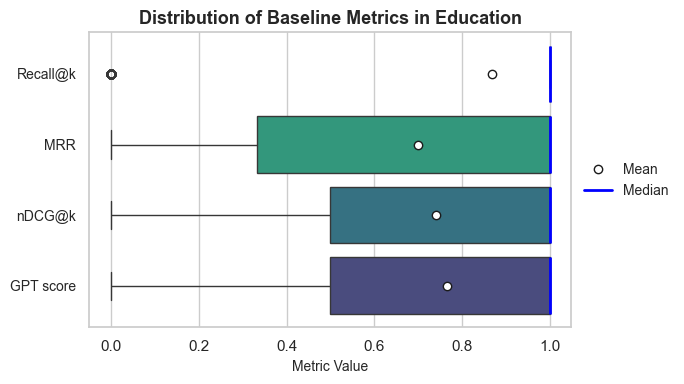

In [31]:
# Define columns to analyze
cols = ['Recall@k', 'MRR', 'nDCG@k', 'gpt_score']
display_cols = ['Recall@k', 'MRR', 'nDCG@k', 'GPT score']
metrics = [f"baseline_{col}" for col in cols]

# Calculate summary statistics
summary_stats = data[metrics].describe()
means = summary_stats.loc['mean']

# Set up SeaGreen palette for the education theme
palette = sns.color_palette("viridis_r", n_colors=len(metrics))

# Plot setup
plt.figure(figsize=(7, 4))
sns.set(style="whitegrid")

# Horizontal boxplot with SeaGreen palette
ax = sns.boxplot(data=data[metrics], orient='h', palette=palette, medianprops={'color': 'blue', 'ls': '-', 'lw': 2})
plt.title("Distribution of Baseline Metrics in Education", fontsize=13, weight='bold')
plt.xlabel("Metric Value", fontsize=10)
plt.yticks(range(len(metrics)), display_cols, fontsize=10)

# Plot a light green dot for the mean of each metric
for i, mean in enumerate(means):
    plt.plot(mean, i, 'o', color='white', markeredgewidth=1, markeredgecolor='k', markersize=6)

# Create custom legend handles for mean and median
mean_handle = mlines.Line2D([], [], color='white', markeredgewidth=1, markeredgecolor='k', marker='o', linestyle='None', markersize=6, label='Mean')
median_handle = mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2, label='Median')

# Add custom legend with mean and median indicators
plt.legend(handles=[mean_handle, median_handle], loc='upper left', bbox_to_anchor=(1.0, 0.6), ncol=1, frameon=False, fontsize=10)

plt.tight_layout()

# Export visualization
# plt.savefig('figures/education_distribution_baseline.png')
# plt.savefig('figures/education_distribution_baseline.svg', format='svg', dpi=1200)

plt.show()

#### 2. Query Transformation 

In [57]:
transformations = ['baseline', 'compression', 'rewriting', 'hyde']

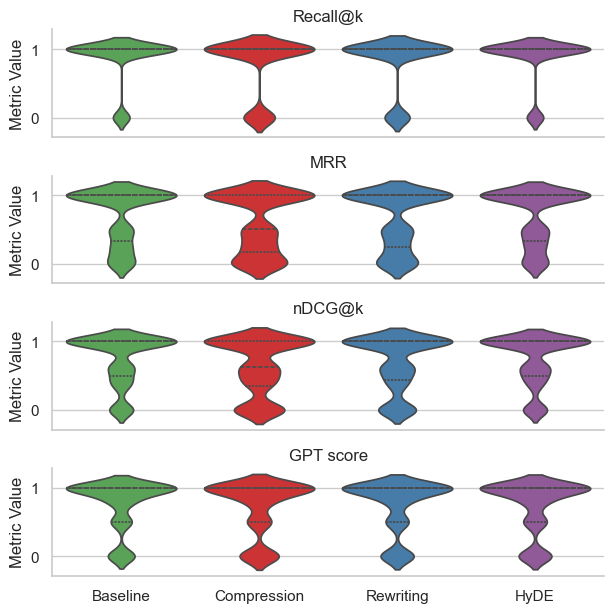

In [38]:
# Reshape the data to a long format suitable for Seaborn FacetGrid
data_long = pd.melt(data, var_name="Transformation_Metric", value_name="Metric Value")

# Split the "Transformation_Metric" column into separate "Transformation" and "Metric" columns
data_long[['Transformation', 'Metric']] = data_long['Transformation_Metric'].str.split('_', n=1, expand=True)

# Adjust values in the "Transformation" column
data_long['Transformation'] = data_long['Transformation'].str.capitalize()
data_long['Transformation'] = data_long['Transformation'].replace({'Hyde': 'HyDE'})

# Define the order of transformations and metrics
transformations = ['Baseline', 'Compression', 'Rewriting', 'HyDE']
metrics = ['Recall@k', 'MRR', 'nDCG@k', 'gpt_score']
display_metrics = ['Recall@k', 'MRR', 'nDCG@k', 'GPT score']

# Set the palette for transformations
palette = ["#4DAF4A", "#E41A1C", "#377EB8", "#984EA3"]

# Create the FacetGrid for each metric, plotting violin plots for each transformation
g = sns.FacetGrid(data_long, row="Metric", hue="Transformation", aspect=3.5, height=1.5, palette=palette, row_order=metrics, hue_order=transformations)
g.map(sns.violinplot, "Transformation", "Metric Value", order=transformations, inner="quartile")

# Adjust facet titles to only show the metric name
for ax, metric in zip(g.axes.flat, display_metrics):
    ax.set_title(f"{metric}")
    ax.set_ylabel("Metric Value")
    ax.set_xlabel("")

# Export visualizations
# plt.savefig('figures/education_distribution_by_transformation.png')
# plt.savefig('figures/education_distribution_by_transformation.svg', format='svg', dpi=1200)

# Adjust layout to make room for the custom legend
plt.tight_layout(rect=[0, 0, 1.2, 1.05])

plt.show()

#### 3. Topic Based Analysis

In [98]:
# Select columns that match the format {transformation}_{metric}, which excludes columns like 'context', 'question', etc.
metric_cols = [col for col in data.columns if '_' in col and col.split('_')[1] in ["Recall@k", "MRR", "nDCG@k", "gpt"]]

# Filter the DataFrame to include only topic_lda and the relevant metric columns
data_filtered = data[['topic_lda'] + metric_cols]

# Reshape the data to a long format suitable for Seaborn
data_long = pd.melt(data_filtered, id_vars=['topic_lda'], var_name="Transformation_Metric", value_name="Metric Value")

# Split "Transformation_Metric" into "Transformation" and "Metric"
data_long[['Transformation', 'Metric']] = data_long['Transformation_Metric'].str.split('_', n=1, expand=True)

# Drop the original "Transformation_Metric" column as it's now split into two columns
data_long = data_long.drop(columns=['Transformation_Metric'])

# Verify the reshaped data structure
print(data_long.head())

   topic_lda  Metric Value Transformation    Metric
0          1           1.0       baseline  Recall@k
1          1           1.0       baseline  Recall@k
2          3           1.0       baseline  Recall@k
3          0           1.0       baseline  Recall@k
4          3           1.0       baseline  Recall@k


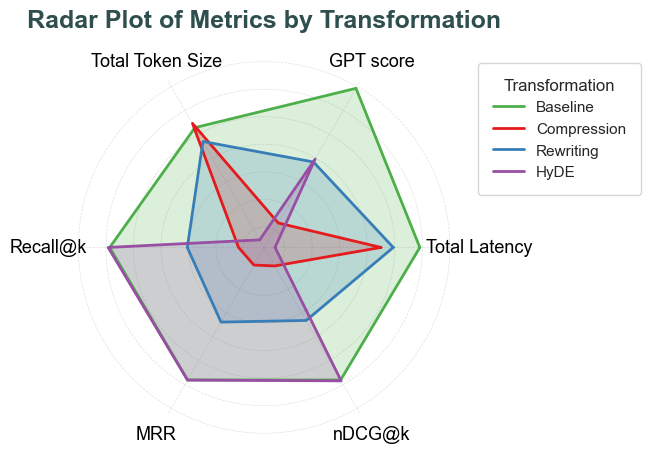

In [40]:
# Transformations and metrics to be plotted
transformations = ["baseline", "compression", "rewriting", "hyde"]
metrics = ["total_latency", "gpt_score", "total_token_size", "Recall@k", "MRR", "nDCG@k"]

# Display-friendly metric names
metric_display_mapping = {
    "total_latency": "Total Latency",
    "gpt_score": "GPT score",
    "total_token_size": "Total Token Size",
    "Recall@k": "Recall@k",
    "MRR": "MRR",
    "nDCG@k": "nDCG@k"
}
display_metrics = [metric_display_mapping[metric] for metric in metrics]

# Capitalized transformation names
transformation_display_mapping = {
    "baseline": "Baseline",
    "compression": "Compression",
    "rewriting": "Rewriting",
    "hyde": "HyDE"
}
display_transformations = [transformation_display_mapping[trans] for trans in transformations]

# Collect data for each transformation and metric
data2 = {
    "total_latency": [data[f"{trans}_total_latency"].mean() for trans in transformations],
    "gpt_score": [data[f"{trans}_gpt_score"].mean() for trans in transformations],
    "total_token_size": [data[f"{trans}_total_token_size"].mean() for trans in transformations],
    "Recall@k": [data[f"{trans}_Recall@k"].mean() for trans in transformations],
    "MRR": [data[f"{trans}_MRR"].mean() for trans in transformations],
    "nDCG@k": [data[f"{trans}_nDCG@k"].mean() for trans in transformations]
}
df = pd.DataFrame(data2, index=transformations)

# Invert metrics where higher values indicate worse performance
metrics_to_invert = ["total_latency", "total_token_size"]
df[metrics_to_invert] = df[metrics_to_invert] * -1

# Normalize data for radar plot using z-score normalization
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=display_transformations)

# Radar plot setup
num_vars = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop for the radar plot

# Set a Seaborn style and color palette
sns.set_theme(style="whitegrid")
colors = ["#4DAF4A", "#E41A1C", "#377EB8", "#984EA3"]

# Initialize the plot with a larger figure size and enhanced layout
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

# Plot each transformation with Seaborn colors and improved styling
for i, (transformation, color) in enumerate(zip(display_transformations, colors)):
    values = df_normalized.loc[transformation].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=transformation, color=color, linewidth=2)
    ax.fill(angles, values, color=color, alpha=0.2)

# Set angle labels to display-friendly metric names
ax.set_xticks(angles[:-1])
ax.set_xticklabels(display_metrics, fontsize=13, color='black')

# Style the radar plot background and remove radial gridlines
ax.set_yticklabels([])
ax.spines['polar'].set_visible(False)  # Remove polar grid
ax.grid(color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

# Title and legend with Seaborn font and position adjustments
plt.title("Radar Plot of Metrics by Transformation", fontsize=18, weight='bold', pad=20, color='darkslategray')
plt.legend(
    title="Transformation",  # Legend title
    loc='upper right', bbox_to_anchor=(1.5, 1.0), frameon=True, fontsize=11, borderpad=1
)

# Export visualizations
# plt.savefig('figures/education_radar_plot_metrics.png', bbox_inches='tight')
# plt.savefig('figures/education_radar_plot_metrics.svg', bbox_inches='tight', format='svg', dpi=1200)

plt.show()


In [24]:
df.head()

,total_latency,gpt_score,total_token_size,Recall@k,MRR,nDCG@k
baseline,-1.457378,0.743384,-1193.252973,0.870270,0.700541,0.742255
compression,-4.059358,0.703168,-1165.430270,0.779459,0.589959,0.636686
rewriting,-2.606709,0.702714,-1277.997838,0.808649,0.633797,0.676701
hyde,-10.441057,0.701686,-2174.899459,0.848649,0.684373,0.725015


In [102]:
# Prepare data by melting transformations and gpt_score based on question_category
data_long = pd.melt(data, id_vars=['question_class'], value_vars=[f"{trans}_gpt_score" for trans in transformations], 
                    var_name="Transformation", value_name="gpt_score")
data_long['Transformation'] = data_long['Transformation'].str.replace('_gpt_score', '')

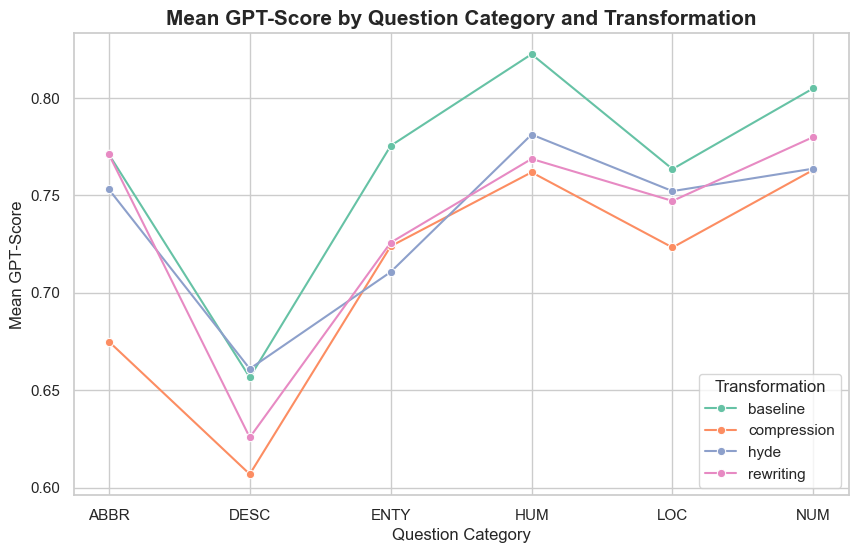

In [103]:
# Calculate mean GPT score per category and transformation
mean_scores = data_long.groupby(['question_class', 'Transformation'])['gpt_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_scores, x='question_class', y='gpt_score', hue='Transformation', marker='o', palette="Set2")
plt.title("Mean GPT-Score by Question Category and Transformation", fontsize=15, weight='bold')
plt.xlabel("Question Category")
plt.ylabel("Mean GPT-Score")
plt.legend(title="Transformation")

# Save visualizations
# plt.savefig('figures/education_evaluation_answer_by_question_cat.svg', format='svg', dpi=1200)
# plt.savefig('figures/education_evaluation_answer_by_question_cat.png')

plt.show()

Definition of Question Classes:
ABBR	abbreviation
ENTY	entities
DESC	description and abstract concepts, definitions
HUM	human beings, organizations, groups
LOC	locations, city, state
NUM	numeric values

## Healthcare


### Preparation

In [68]:
# Load the individual CSV files
baseline_df = pd.read_csv("data/healthcare/processed/2_healthcare_baseline.csv")
compression_df = pd.read_csv("data/healthcare/processed/2_healthcare_compression.csv")
cookbook_df = pd.read_csv("data/healthcare/processed/2_healthcare_cookbook.csv")
hyde_df = pd.read_csv("data/healthcare/processed/2_healthcare_hyde.csv")

# Define columns to add prefixes to, which are transformation-specific
transformation_specific_cols = ['token_query', 'token_query_full_prompt', 'total_token_size', 
                                'transformation_latency', 'generated_answer', 'gpt_score',
                                'Recall@k', 'MRR', 'nDCG@k', 'total_latency']

# Function to add prefixes to transformation-specific columns
def add_prefix(df, prefix, columns):
    df = df.rename(columns={col: f"{prefix}_{col}" for col in columns})
    # Rename non-transformation-specific columns (e.g., query, latency) to avoid duplication
    return df.rename(columns={col: f"{prefix}_{col}" for col in ['query', 'retrieval_generation_latency']})

# Apply renaming with prefixes for each transformation DataFrame
baseline_df = add_prefix(baseline_df, 'baseline', transformation_specific_cols)
compression_df = add_prefix(compression_df, 'compression', transformation_specific_cols)
cookbook_df = add_prefix(cookbook_df, 'rewriting', transformation_specific_cols)
hyde_df = add_prefix(hyde_df, 'hyde', transformation_specific_cols)

# Merge all DataFrames on shared columns (context, question, answer, topic_lda)
# Specify suffixes to handle any potential overlapping non-prefixed columns
unified_df = baseline_df.merge(compression_df, on=['context', 'question', 'answer', 'topic_lda'], how='outer') \
                        .merge(cookbook_df, on=['context', 'question', 'answer', 'topic_lda'], how='outer') \
                        .merge(hyde_df, on=['context', 'question', 'answer', 'topic_lda'], how='outer')

# Display structure of the unified DataFrame for validation
unified_df.head()

,context,question,answer,topic_lda,baseline_query,baseline_token_query,baseline_token_query_full_prompt,baseline_total_token_size,baseline_Recall@k,baseline_MRR,...,hyde_token_query_full_prompt,hyde_total_token_size,hyde_Recall@k,hyde_MRR,hyde_nDCG@k,hyde_transformation_latency,hyde_retrieval_generation_latency,hyde_total_latency,hyde_generated_answer,hyde_gpt_score
0,37 million individuals are currently infected ...,Are reductions in microfilaridermia by repeate...,"Consequently, areas with a lowered infection p...",0,Are reductions in microfilaridermia by repeate...,37.0,2312.0,2416,1.0,0.333333,...,2885.0,3547,1.0,0.166667,0.356207,5.839116,1.717607,8.497937,"Yes, reductions in microfilaridermia by repeat...",0.7
1,A collaborative care (CC) intervention for pat...,Do cost-effectiveness and cost offset of a col...,A CC intervention for patients with panic diso...,1,Do cost-effectiveness and cost offset of a col...,20.0,1808.0,1882,1.0,1.000000,...,2471.0,2997,1.0,1.000000,1.000000,3.625208,2.522778,7.347028,"Yes, the collaborative care (CC) intervention ...",0.8
2,A distinction between a benign follicular neop...,Is preoperative serum thyroglobulin concentrat...,The independent predictors of malignancy in FN...,0,Is preoperative serum thyroglobulin concentrat...,27.0,2253.0,2283,0.0,0.000000,...,2765.0,3421,0.0,0.000000,0.000000,5.794953,1.487350,8.400198,"No, preoperative serum thyroglobulin concentra...",0.0
3,A fine needle aspiration (FNA) diagnosis of a ...,Does tumor size predict malignant potential in...,Tumor size correlates directly with malignant ...,1,Does tumor size predict malignant potential in...,19.0,2216.0,2278,1.0,1.000000,...,2366.0,2910,1.0,1.000000,1.000000,4.533228,3.640928,9.434080,"Yes, tumor size predicts malignant potential i...",0.9
4,A gene polymorphism substituting arginine (R) ...,Is the Fcγ receptor IIA R131H gene polymorphis...,The R allele of the FcγRIIa polymorphism is as...,0,Is the Fcγ receptor IIA R131H gene polymorphis...,26.0,2404.0,2472,1.0,1.000000,...,2964.0,3589,1.0,0.500000,0.630930,5.060242,1.596698,7.696706,"Yes, the Fcγ receptor IIA R131H gene polymorph...",0.7


### Quality Check

In [69]:
# Check for missing values across the DataFrame
missing_values = unified_df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])

Missing values in each column:
 Series([], dtype: int64)


In [70]:
# Check for duplicate rows based on essential columns
duplicates = unified_df.duplicated(subset=['context', 'question', 'answer', 'topic_lda'])
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [71]:
# Check if metric columns fall within expected ranges
metric_columns = [col for col in unified_df.columns if 'Recall@k' in col or 'MRR' in col or 'nDCG@k' in col]
for col in metric_columns:
    assert unified_df[col].between(0, 1).all(), f"Values out of range in column: {col}"

# Check for non-negative latency values
latency_columns = [col for col in unified_df.columns if 'latency' in col]
for col in latency_columns:
    assert (unified_df[col] >= 0).all(), f"Negative values found in column: {col}"

In [72]:
# Check for both NaN and empty string values
def find_missing_and_empty_values(df):
    # Identify columns with NaN values
    nan_counts = df.isna().sum()
    nan_counts = nan_counts[nan_counts > 0]
    
    # Identify columns with empty strings or whitespace only
    empty_counts = (df.applymap(lambda x: isinstance(x, str) and x.strip() == '')
                    .sum())
    empty_counts = empty_counts[empty_counts > 0]
    
    # Combine the counts
    missing_info = pd.DataFrame({'NaN Count': nan_counts, 'Empty String Count': empty_counts}).fillna(0)
    
    print("Columns with missing or empty values:\n", missing_info)

# Call the function on your unified DataFrame
find_missing_and_empty_values(unified_df)

Columns with missing or empty values:
 Empty DataFrame
Columns: [NaN Count, Empty String Count]
Index: []


C:\Users\Emir\AppData\Local\Temp\ipykernel_3352\3752105210.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_counts = (df.applymap(lambda x: isinstance(x, str) and x.strip() == '')


### Testing

In [73]:
# Load the original CSV files into a dictionary with transformation names as keys
original_files = {
    'baseline': pd.read_csv("data/healthcare/processed/2_healthcare_baseline.csv"),
    'compression': pd.read_csv("data/healthcare/processed/2_healthcare_compression.csv"),
    'rewriting': pd.read_csv("data/healthcare/processed/2_healthcare_cookbook.csv"),
    'hyde': pd.read_csv("data/healthcare/processed/2_healthcare_hyde.csv")
}

def print_random_question_and_compare(df):
    # Randomly select a row from the unified DataFrame
    random_index = random.choice(df.index)
    selected_row = df.loc[random_index]
    question = selected_row['question']
    
    # Randomly choose one transformation type
    transformation = random.choice(list(original_files.keys()))
    original_df = original_files[transformation]
    
    print(f"\nRandomly selected transformation: {transformation}")
    print("Values in unified_df for the selected question and transformation:")
    
    # Define columns of interest and add transformation prefix for unified_df
    base_columns = ['context', 'question', 'answer', 'topic_lda', 'query', 
                    'Recall@k', 'MRR', 'nDCG@k', 'generated_answer', 'gpt_score']
    prefixed_columns = [f"{transformation}_{col}" for col in base_columns]
    
    # Filter to only include available prefixed columns in unified_df
    available_columns = [col for col in prefixed_columns if col in df.columns]
    
    # Print the selected row's values for the transformation
    print(selected_row[available_columns])

    # Look up the same question in the selected original file
    original_row = original_df[original_df['question'] == question]
    
    # Print out values from the original file if the question is found
    if not original_row.empty:
        print(f"\nOriginal values from '{transformation}' CSV for the same question:")
        available_columns_original = [col for col in base_columns if col in original_row.columns]
        print(original_row[available_columns_original].iloc[0])  # Display the first match only
    else:
        print(f"\nQuestion not found in the original '{transformation}' CSV.")

# Run the function on the unified DataFrame
print_random_question_and_compare(unified_df)


Randomly selected transformation: rewriting
Values in unified_df for the selected question and transformation:
rewriting_query               Are posterior circulatory events more frequent...
rewriting_Recall@k                                                          1.0
rewriting_MRR                                                               1.0
rewriting_nDCG@k                                                            1.0
rewriting_generated_answer    No, the preponderance of posterior circulatory...
rewriting_gpt_score                                                         0.0
Name: 120, dtype: object

Original values from 'rewriting' CSV for the same question:
context             Central nervous system complications of cardia...
question            Is the preponderance of posterior circulatory ...
answer              The preponderance of posterior circulatory eve...
topic_lda                                                           1
query               Are posterior circulat

In [78]:
print_random_question_and_compare(unified_df)


Randomly selected transformation: hyde
Values in unified_df for the selected question and transformation:
hyde_query               Does binge ethanol exposure increase liver inj...
hyde_Recall@k                                                          1.0
hyde_MRR                                                               1.0
hyde_nDCG@k                                                            1.0
hyde_generated_answer    Yes, binge ethanol exposure increases liver in...
hyde_gpt_score                                                         0.7
Name: 655, dtype: object

Original values from 'hyde' CSV for the same question:
context             The objective of this study was to address the...
question            Does binge ethanol exposure increase liver inj...
answer              These data indicate that binge drinking increa...
topic_lda                                                           0
query               Does binge ethanol exposure increase liver inj...
Recall@k    

In [75]:
print_random_question_and_compare(unified_df)


Randomly selected transformation: baseline
Values in unified_df for the selected question and transformation:
baseline_query               Does oRC1 interact with c-Myc to inhibit E-box...
baseline_Recall@k                                                          1.0
baseline_MRR                                                              0.25
baseline_nDCG@k                                                       0.430677
baseline_generated_answer    Yes, ORC1 interacts with c-Myc to inhibit E-bo...
baseline_gpt_score                                                         0.5
Name: 602, dtype: object

Original values from 'baseline' CSV for the same question:
context             The c-myc oncogene product (c-Myc) is a transc...
question            Does oRC1 interact with c-Myc to inhibit E-box...
answer              These results suggest that ORC1 suppresses the...
topic_lda                                                           0
query               Does oRC1 interact with c-Myc 

In [79]:
# Save healthcare dataset for analysis
unified_df.to_csv("data/healthcare/processed/3_healthcare_analysis.csv", index=False)

### Baseline Analysis

In [43]:
# Load the healthcare baseline analysis data
data = pd.read_csv("data/healthcare/processed/3_healthcare_analysis.csv")

In [44]:
data.columns

Index(['context', 'question', 'answer', 'topic_lda', 'baseline_query',
       'baseline_token_query', 'baseline_token_query_full_prompt',
       'baseline_total_token_size', 'baseline_Recall@k', 'baseline_MRR',
       'baseline_nDCG@k', 'baseline_transformation_latency',
       'baseline_retrieval_generation_latency', 'baseline_total_latency',
       'baseline_generated_answer', 'baseline_gpt_score', 'compression_query',
       'compression_token_query', 'compression_token_query_full_prompt',
       'compression_total_token_size', 'compression_Recall@k',
       'compression_MRR', 'compression_nDCG@k',
       'compression_transformation_latency',
       'compression_retrieval_generation_latency', 'compression_total_latency',
       'compression_generated_answer', 'compression_gpt_score',
       'rewriting_query', 'rewriting_token_query',
       'rewriting_token_query_full_prompt', 'rewriting_total_token_size',
       'rewriting_Recall@k', 'rewriting_MRR', 'rewriting_nDCG@k',
       'rew

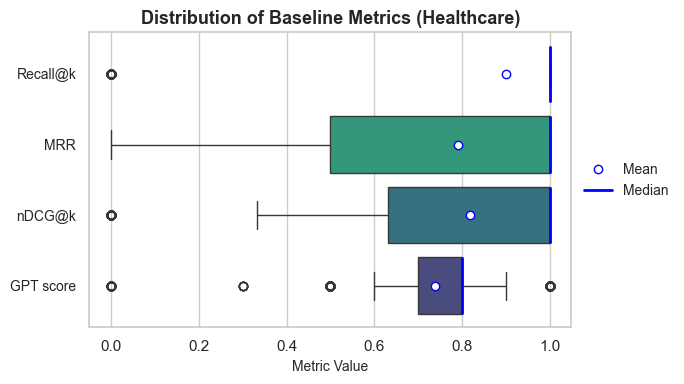

In [50]:
# Define columns to analyze
cols = ['Recall@k', 'MRR', 'nDCG@k', 'gpt_score']
display_cols = ['Recall@k', 'MRR', 'nDCG@k', 'GPT score']
metrics = [f"baseline_{col}" for col in cols]

# Calculate summary statistics
summary_stats = data[metrics].describe()
means = summary_stats.loc['mean']

# Set up palette
palette = sns.color_palette("viridis_r", n_colors=len(metrics))

# Plot setup
plt.figure(figsize=(7, 4))
sns.set(style="whitegrid")

# Horizontal boxplot
ax = sns.boxplot(data=data[metrics], orient='h', palette=palette, medianprops={'color': 'blue', 'ls': '-', 'lw': 2})
plt.title("Distribution of Baseline Metrics (Healthcare)", fontsize=13, weight='bold')
plt.xlabel("Metric Value", fontsize=10)
plt.yticks(range(len(metrics)), display_cols, fontsize=10)

# Plot a dot for the mean of each metric
for i, mean in enumerate(means):
    plt.plot(mean, i, 'o', color='white', markeredgewidth=1, markeredgecolor='blue', markersize=6)

# Create custom legend handles for mean and median
mean_handle = mlines.Line2D([], [], color='white', markeredgewidth=1, markeredgecolor='blue', marker='o', linestyle='None', markersize=6, label='Mean')
median_handle = mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2, label='Median')

# Add custom legend with mean and median indicators
plt.legend(handles=[mean_handle, median_handle], loc='upper left', bbox_to_anchor=(1.0, 0.6), ncol=1, frameon=False, fontsize=10)

# Save visualization
# plt.savefig('figures/healthcare_distribution_baseline.png', bbox_inches='tight')
# plt.savefig('figures/healthcare_distribution_baseline.svg', bbox_inches='tight', format='svg', dpi=1200)

plt.tight_layout()

plt.show()

#### 2. Query Transformation 

In [3]:
transformations = ['baseline', 'compression', 'rewriting', 'hyde']

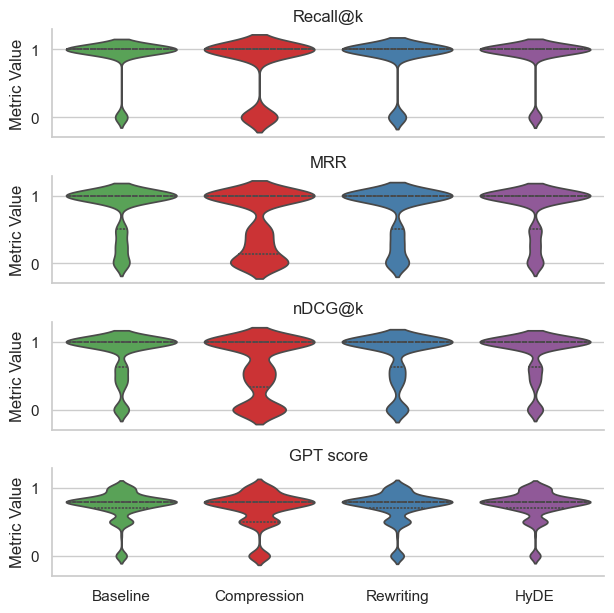

In [52]:
# Reshape the data to a long format suitable for Seaborn FacetGrid
data_long = pd.melt(data, var_name="Transformation_Metric", value_name="Metric Value")

# Split the "Transformation_Metric" column into separate "Transformation" and "Metric" columns
data_long[['Transformation', 'Metric']] = data_long['Transformation_Metric'].str.split('_', n=1, expand=True)

# Adjust values in the "Transformation" column
data_long['Transformation'] = data_long['Transformation'].str.capitalize()
data_long['Transformation'] = data_long['Transformation'].replace({'Hyde': 'HyDE'})

# Define the order of transformations and metrics
transformations = ['Baseline', 'Compression', 'Rewriting', 'HyDE']
metrics = ['Recall@k', 'MRR', 'nDCG@k', 'gpt_score']
display_metrics = ['Recall@k', 'MRR', 'nDCG@k', 'GPT score']

# Set the palette for transformations
palette = ["#4DAF4A", "#E41A1C", "#377EB8", "#984EA3"]

# Create the FacetGrid for each metric, plotting violin plots for each transformation
g = sns.FacetGrid(data_long, row="Metric", hue="Transformation", aspect=3.5, height=1.5, palette=palette, row_order=metrics, hue_order=transformations)
g.map(sns.violinplot, "Transformation", "Metric Value", order=transformations, inner="quartile")

# Adjust facet titles to only show the metric name
for ax, metric in zip(g.axes.flat, display_metrics):
    ax.set_title(f"{metric}")
    ax.set_ylabel("Metric Value")
    ax.set_xlabel("")

# Export visualizations
# plt.savefig('figures/healthcare_distribution_by_transformation.png')
# plt.savefig('figures/healthcare_distribution_by_transformation.svg', format='svg', dpi=1200)

# Adjust layout to make room for the custom legend
plt.tight_layout(rect=[0, 0, 1.2, 1.05])

plt.show()

#### 3. Topic Based Analysis

In [44]:
# Select columns that match the format {transformation}_{metric}, which excludes columns like 'context', 'question', etc.
metric_cols = [col for col in data.columns if '_' in col and col.split('_')[1] in ["Recall@k", "MRR", "nDCG@k", "gpt"]]

# Filter the DataFrame to include only topic_lda and the relevant metric columns
data_filtered = data[['topic_lda'] + metric_cols]

# Reshape the data to a long format suitable for Seaborn
data_long = pd.melt(data_filtered, id_vars=['topic_lda'], var_name="Transformation_Metric", value_name="Metric Value")

# Split "Transformation_Metric" into "Transformation" and "Metric"
data_long[['Transformation', 'Metric']] = data_long['Transformation_Metric'].str.split('_', n=1, expand=True)

# Drop the original "Transformation_Metric" column as it's now split into two columns
data_long = data_long.drop(columns=['Transformation_Metric'])

# Verify the reshaped data structure
print(data_long.head())

   topic_lda  Metric Value Transformation    Metric
0          0           1.0       baseline  Recall@k
1          1           1.0       baseline  Recall@k
2          0           0.0       baseline  Recall@k
3          1           1.0       baseline  Recall@k
4          0           1.0       baseline  Recall@k


In [90]:
df.head()

,total_latency,gpt_score,total_token_size,Recall@k,MRR,nDCG@k
baseline,-2.929393,0.737742,-2354.841935,0.901075,0.790415,0.817579
compression,-4.205562,0.687957,-2337.476344,0.752688,0.598840,0.636686
rewriting,-5.726369,0.722903,-2456.464516,0.863441,0.751359,0.779016
hyde,-9.197384,0.741935,-3329.140860,0.897849,0.794030,0.819746


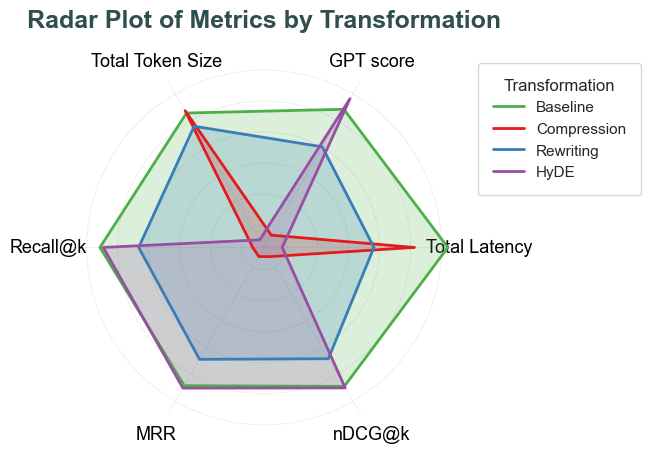

In [55]:
# Transformations and metrics to be plotted
transformations = ["baseline", "compression", "rewriting", "hyde"]
metrics = ["total_latency", "gpt_score", "total_token_size", "Recall@k", "MRR", "nDCG@k"]

# Display-friendly metric names
metric_display_mapping = {
    "total_latency": "Total Latency",
    "gpt_score": "GPT score",
    "total_token_size": "Total Token Size",
    "Recall@k": "Recall@k",
    "MRR": "MRR",
    "nDCG@k": "nDCG@k"
}
display_metrics = [metric_display_mapping[metric] for metric in metrics]

# Capitalized transformation names
transformation_display_mapping = {
    "baseline": "Baseline",
    "compression": "Compression",
    "rewriting": "Rewriting",
    "hyde": "HyDE"
}
display_transformations = [transformation_display_mapping[trans] for trans in transformations]

# Collect data for each transformation and metric
data2 = {
    "total_latency": [data[f"{trans}_total_latency"].mean() for trans in transformations],
    "gpt_score": [data[f"{trans}_gpt_score"].mean() for trans in transformations],
    "total_token_size": [data[f"{trans}_total_token_size"].mean() for trans in transformations],
    "Recall@k": [data[f"{trans}_Recall@k"].mean() for trans in transformations],
    "MRR": [data[f"{trans}_MRR"].mean() for trans in transformations],
    "nDCG@k": [data[f"{trans}_nDCG@k"].mean() for trans in transformations]
}
df = pd.DataFrame(data2, index=transformations)

# Invert metrics where higher values indicate worse performance
metrics_to_invert = ["total_latency", "total_token_size"]
df[metrics_to_invert] = df[metrics_to_invert] * -1

# Normalize data for radar plot using z-score normalization
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=display_transformations)

# Radar plot setup
num_vars = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Set a Seaborn style and color palette
sns.set_theme(style="whitegrid")
colors = ["#4DAF4A", "#E41A1C", "#377EB8", "#984EA3"]

# Initialize the plot with a larger figure size and enhanced layout
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

# Plot each transformation with Seaborn colors and improved styling
for i, (transformation, color) in enumerate(zip(display_transformations, colors)):
    values = df_normalized.loc[transformation].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=transformation, color=color, linewidth=2)
    ax.fill(angles, values, color=color, alpha=0.2)

# Set angle labels to display-friendly metric names
ax.set_xticks(angles[:-1])
ax.set_xticklabels(display_metrics, fontsize=13, color='black')

# Style the radar plot background and remove radial gridlines
ax.set_yticklabels([])
ax.spines['polar'].set_visible(False)  # Remove polar grid
ax.grid(color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)

# Title and legend with Seaborn font and position adjustments
plt.title("Radar Plot of Metrics by Transformation", fontsize=18, weight='bold', pad=20, color='darkslategray')
plt.legend(
    title="Transformation",  # Legend title
    loc='upper right', bbox_to_anchor=(1.5, 1.0), frameon=True, fontsize=11, borderpad=1
)

# Export visualizations
# plt.savefig('figures/healthcare_radar_plot_metrics.png', bbox_inches='tight')
# plt.savefig('figures/healthcare_radar_plot_metrics.svg', bbox_inches='tight', format='svg', dpi=1200)

plt.show()


In [54]:
df.head()

,total_latency,gpt_score,total_token_size,Recall@k,MRR,nDCG@k
baseline,-2.929393,0.737742,-2354.841935,0.901075,0.790415,0.817579
compression,-4.205562,0.687957,-2337.476344,0.752688,0.598840,0.636686
rewriting,-5.726369,0.722903,-2456.464516,0.863441,0.751359,0.779016
hyde,-9.197384,0.741935,-3329.140860,0.897849,0.794030,0.819746


## Outlook

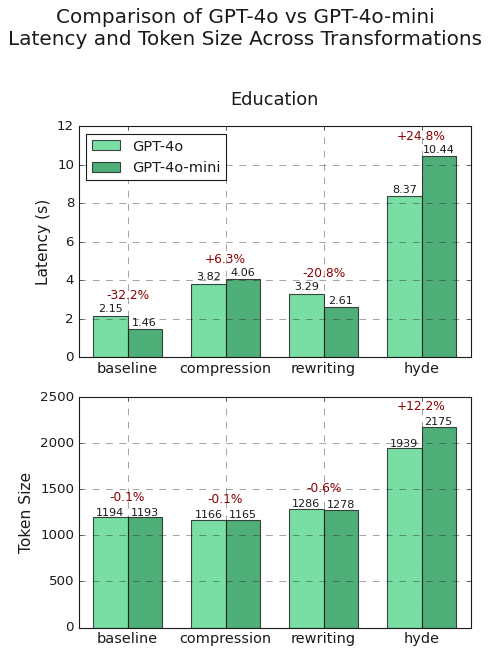

In [84]:
# Load the data
data_gpt4o = pd.read_csv("data/education/processed/3_education_analysis.csv")
data_gpt4o_mini = pd.read_csv("data/education/processed/mini-recalc3/3_education_analysis.csv")

# Transformations to analyze
transformations = ["baseline", "compression", "rewriting", "hyde"]

# Calculate mean latencies and token sizes for each transformation and model
latencies_gpt4o = [data_gpt4o[f"{trans}_total_latency"].mean() for trans in transformations]
latencies_gpt4o_mini = [data_gpt4o_mini[f"{trans}_total_latency"].mean() for trans in transformations]
token_sizes_gpt4o = [int(round(data_gpt4o[f"{trans}_total_token_size"].mean())) for trans in transformations]
token_sizes_gpt4o_mini = [int(round(data_gpt4o_mini[f"{trans}_total_token_size"].mean())) for trans in transformations]

# Use the classic style
plt.style.use('classic')

# Modify the figure background color to white
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), height_ratios=[1, 1])

# Define width and positions
width = 0.35
x = np.arange(len(transformations))

# Define colors
colors_gpt4o = ['#58D68D', '#58D68D', '#58D68D', '#58D68D']
colors_gpt4o_mini = ['#239B56', '#239B56', '#239B56', '#239B56']

# Latency subplot
bars1 = ax1.bar(x - width/2, latencies_gpt4o, width, label='GPT-4o', color=colors_gpt4o, alpha=0.8)
bars2 = ax1.bar(x + width/2, latencies_gpt4o_mini, width, label='GPT-4o-mini', color=colors_gpt4o_mini, alpha=0.8)

# Add value labels on the bars for latency
def add_value_labels(ax, bars, round_to_int=True):
    for bar in bars:
        height = bar.get_height()
        if round_to_int:
            label = f'{int(height)}' 
        else:
            label = f'{height:.2f}'
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 0.1,
            label,
            ha='center',
            va='bottom',
            fontsize=10
        )

add_value_labels(ax1, bars1, round_to_int=False)
add_value_labels(ax1, bars2, round_to_int=False)

# Customize latency subplot
ax1.set_ylabel('Latency (s)', fontsize=14)
ax1.set_title('Education', pad=20, fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(transformations, fontsize=13)
ax1.legend(loc='upper left', fontsize=13)
ax1.grid(True, linestyle='--', alpha=0.7)

# Token size subplot
bars3 = ax2.bar(x - width/2, token_sizes_gpt4o, width, label='GPT-4o', color=colors_gpt4o, alpha=0.8)
bars4 = ax2.bar(x + width/2, token_sizes_gpt4o_mini, width, label='GPT-4o-mini', color=colors_gpt4o_mini, alpha=0.8)

# Add value labels on the bars for token size
add_value_labels(ax2, bars3, round_to_int=True)
add_value_labels(ax2, bars4, round_to_int=True)

# Customize token size subplot
ax2.set_ylabel('Token Size', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(transformations, fontsize=13)
ax2.grid(True, linestyle='--', alpha=0.7)

# Overall plot adjustments
plt.suptitle('Comparison of GPT-4o vs GPT-4o-mini\nLatency and Token Size Across Transformations',
             fontsize=18, y=1.02)
plt.tight_layout()

# Adjust percentage difference annotations
def add_percentage_diff(ax, values1, values2, offset_factor=0.07):
    max_value = max(max(values1), max(values2))
    offset = offset_factor * max_value
    for i in range(len(values1)):
        pct_diff = ((values2[i] - values1[i]) / values1[i]) * 100
        ax.text(i, max(values1[i], values2[i]) + offset, f'{pct_diff:+.1f}%',
                ha='center', va='bottom', color='darkred', fontsize=11)

add_percentage_diff(ax1, latencies_gpt4o, latencies_gpt4o_mini)
add_percentage_diff(ax2, token_sizes_gpt4o, token_sizes_gpt4o_mini)

# Save visualizations
# plt.savefig('figures/comparison_analysis_edu.png', dpi=300, bbox_inches='tight')
# plt.savefig('figures/comparison_analysis_edu.svg', format='svg', dpi=1200, bbox_inches='tight')

# Show the plot
plt.show()

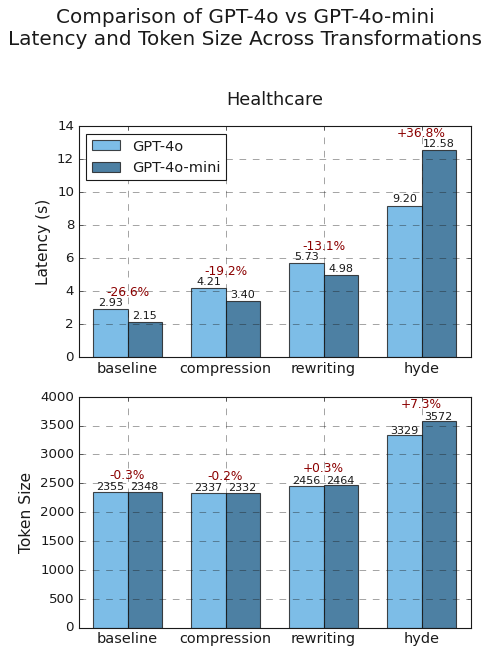

In [85]:
# Load the data
data_gpt4o = pd.read_csv("data/healthcare/processed/3_healthcare_analysis.csv")
data_gpt4o_mini = pd.read_csv("data/healthcare/processed/mini-recalc3/3_healthcare_analysis.csv")

# Transformations to analyze
transformations = ["baseline", "compression", "rewriting", "hyde"]

# Calculate mean latencies and token sizes for each transformation and model
latencies_gpt4o = [data_gpt4o[f"{trans}_total_latency"].mean() for trans in transformations]
latencies_gpt4o_mini = [data_gpt4o_mini[f"{trans}_total_latency"].mean() for trans in transformations]
token_sizes_gpt4o = [int(round(data_gpt4o[f"{trans}_total_token_size"].mean())) for trans in transformations]
token_sizes_gpt4o_mini = [int(round(data_gpt4o_mini[f"{trans}_total_token_size"].mean())) for trans in transformations]

# Use the classic style
plt.style.use('classic')

# Modify the figure background color to white
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), height_ratios=[1, 1])

# Define width and positions
width = 0.35
x = np.arange(len(transformations))

# Colors
colors_gpt4o = ['#5DADE2', '#5DADE2', '#5DADE2', '#5DADE2']
colors_gpt4o_mini = ['#21618C', '#21618C', '#21618C', '#21618C']

# Latency subplot
bars1 = ax1.bar(x - width/2, latencies_gpt4o, width, label='GPT-4o', color=colors_gpt4o, alpha=0.8)
bars2 = ax1.bar(x + width/2, latencies_gpt4o_mini, width, label='GPT-4o-mini', color=colors_gpt4o_mini, alpha=0.8)

# Add value labels on the bars for latency
def add_value_labels(ax, bars, round_to_int=True):
    for bar in bars:
        height = bar.get_height()
        if round_to_int:
            label = f'{int(height)}'
        else:
            label = f'{height:.2f}'
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + 0.1,
            label,
            ha='center',
            va='bottom',
            fontsize=10
        )


add_value_labels(ax1, bars1, round_to_int=False)
add_value_labels(ax1, bars2, round_to_int=False)

# Customize latency subplot
ax1.set_ylabel('Latency (s)', fontsize=14)
ax1.set_title('Healthcare', pad=20, fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(transformations, fontsize=13)
ax1.legend(loc='upper left', fontsize=13)
ax1.grid(True, linestyle='--', alpha=0.7)

# Token size subplot
bars3 = ax2.bar(x - width/2, token_sizes_gpt4o, width, label='GPT-4o', color=colors_gpt4o, alpha=0.8)
bars4 = ax2.bar(x + width/2, token_sizes_gpt4o_mini, width, label='GPT-4o-mini', color=colors_gpt4o_mini, alpha=0.8)

# Add value labels on the bars for token size
add_value_labels(ax2, bars3, round_to_int=True)
add_value_labels(ax2, bars4, round_to_int=True)

# Customize token size subplot
ax2.set_ylabel('Token Size', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(transformations, fontsize=13)
ax2.grid(True, linestyle='--', alpha=0.7)

# Overall plot adjustments
plt.suptitle('Comparison of GPT-4o vs GPT-4o-mini\nLatency and Token Size Across Transformations',
             fontsize=18, y=1.02)
plt.tight_layout()

# Adjust percentage difference annotations
def add_percentage_diff(ax, values1, values2, offset_factor=0.05):
    max_value = max(max(values1), max(values2))
    offset = offset_factor * max_value
    for i in range(len(values1)):
        pct_diff = ((values2[i] - values1[i]) / values1[i]) * 100
        ax.text(i, max(values1[i], values2[i]) + offset, f'{pct_diff:+.1f}%',
                ha='center', va='bottom', color='darkred', fontsize=11)

add_percentage_diff(ax1, latencies_gpt4o, latencies_gpt4o_mini)
add_percentage_diff(ax2, token_sizes_gpt4o, token_sizes_gpt4o_mini)

# Save visualizations
# plt.savefig('figures/comparison_analysis_hc.png', dpi=300, bbox_inches='tight')
# plt.savefig('figures/comparison_analysis_hc.svg', format='svg', dpi=1200, bbox_inches='tight')

# Show the plot
plt.show()